# 1. Supervised Learning & Backpropagation



Objectives of Practical 2:

*   To understand the training process, including backpropagation, without relying on machine learning libraries

*   Getting introduced to ML libraries

In [2]:
# @title Defining the dataset and the neural network (from tutorial 1)

# importing libraries
import numpy as np
import matplotlib.pyplot as plt

#the dataset defined by the logical operator AND
dataset_and = [
                ([0, 0], 0),
                ([0, 1], 0),
                ([1, 0], 0),
                ([1, 1], 1)
                ]

#the dataset defined by the logical operator OR
dataset_or = [
                ([0, 0], 0),
                ([0, 1], 1),
                ([1, 0], 1),
                ([1, 1], 1)
                ]

#the dataset defined by the logical operator XOR
dataset_xor = [
                ([0, 0], 0),
                ([0, 1], 1),
                ([1, 0], 1),
                ([1, 1], 0)
                ]

#the dataset defined by the logical operator XNOR
dataset_xnor = [
                ([0, 0], 1),
                ([0, 1], 0),
                ([1, 0], 0),
                ([1, 1], 1)
                ]

# Batch Creation: Using a dataset D and a specified batch_size N, this function
# selects N random samples from D. It returns a tuple containing ordered arrays:
# (inputs, targets). For each entry, targets[i] matches the target for inputs[i].

def generate_batch(dataset, batch_size):
    #differentiate inputs (features) from targets and transform each into
    #numpy array with each row as an example
    inputs = np.vstack([ex[0] for ex in dataset])
    targets = np.vstack([ex[1] for ex in dataset])

    #randomly choose batch_size many examples; note there will be
    #duplicate entries when batch_size > len(dataset)
    rand_inds = np.random.randint(0, len(dataset), batch_size)
    inputs_batch = inputs[rand_inds]
    targets_batch = targets[rand_inds]

    return inputs_batch, targets_batch

#code for *nn_one_layer* which initiliases the model and also defines the forward
#computation.

def sigmoid(a):
    sigma = 1/(1 + np.exp(-a))
    return sigma


class nn_one_layer():
    def __init__(self, input_size, hidden_size, output_size):
        #define the input/output weights Wax, Wya
        self.Wax = 0.1 * np.random.randn(input_size, hidden_size)
        self.Wya = 0.1 * np.random.randn(hidden_size, output_size)

        self.f = sigmoid

    def forward(self, x):
        z = np.matmul(x, self.Wax)
        a = self.f(z)
        yhat = np.matmul(a, self.Wya)
        return yhat, a, z

## 1.2 The Loss Function


The loss function at its most basic tells you the discrepancy between the predicted values and the actual ground truth values for a particular training example. The goal is to minimise the loss.

Here we will use the **Squared Error** loss

$$J_k = (\hat{y_k} - t_k)^2$$

where $t_k$ is the target value, $\hat{y_k}$ is the output prediction for the $k^{\mathrm{th}}$ sample input.

In the code below, we will drop the $k$ subscripts, for conciseness.


In [15]:
def loss_mse(predictions, targets):
    # calculate number of training examples

    loss_J = (1/len(predictions)) * sum((predictions - targets) ** 2)
    return loss_J

**Derivative of the Loss Function:**
The derivative of the loss function with respect to predictions indicates the direction and magnitude of changes needed to reduce the loss.

In [4]:
def loss_deriv(predictions, targets):
    dJ_dyhat = 2 * (predictions - targets)
    return dJ_dyhat

## 1.3. Activation Functions and Their Derivatives

We have already come across the sigmoid activation function

$\sigma(z) =\frac{1}{1+e^{-z}}$

in tutorial 1.

The derivative of the activation function is used during backpropagation to adjust the weights in the direction that reduces the loss.

If you want a nice calculus exercise, calculate the derivitave of the sigmoid.

If you don't want a nice calculus exercise, the answer is:

$\frac{d\sigma(z)}{dz} =\sigma(z)(1-\sigma(z))$

Implement this now in code.




In [5]:
#derivative of the sigmoid function
def sigmoid_prime(z):
    dsigmoid_dz = sigmoid(z) * (1 - sigmoid(z))
    return dsigmoid_dz

## 1.4. Backpropagation


**Step-by-step Process:**

1. Forward Pass: Before we can start backpropagation, we n
eed to do a forward pass through the network to get the predictions. This also allows us to compute the initial loss.

A reminder of the equations for the forward pass. Note that (in contrast to the lecture slides), the final layer activity does not pass through a nonlinearity at the output stage. This simplifies the gradient calculation a little.

\begin{align}
\mathbf{Z} &= \mathbf{X}W_{a←x} \\
\mathbf{A} &= f(\mathbf{Z}) \\
\hat{y} &= \mathbf{A}W_{y←a}
\end{align}



2. Compute the Gradient at the Output.

3. Move Backwards Through the Network: Starting from the output layer and moving towards the input layer, we compute the gradient of the loss concerning each weight. This is done by multiplying the gradient we have by the local gradient of the current layer. This step is iteratively repeated for each layer in the network.


\begin{align}
\frac{\delta\mathbf{J}}{\delta W_{y←a}} &= \frac{\delta \hat{y}}{\delta W_{y←a}} \frac{\delta\mathbf{J}}{\delta \hat{y}} = \mathbf{A}^T \frac{\delta\mathbf{J}}{\delta \hat{y}} \\
\frac{\delta\mathbf{J}}{\delta A} &= \frac{\delta \hat{y}}{\delta A} \frac{\delta\mathbf{J}}{\delta \hat{y}} =  \frac{\delta\mathbf{J}}{\delta \hat{y}} W_{y←a}^T \\
\frac{\delta\mathbf{J}}{\delta Z} &= \sigma'(\mathbf{Z})\odot \frac{\delta\mathbf{J}}{\delta A} \\
\frac{\delta\mathbf{J}}{\delta W_{a←x}} &= \mathbf{X}^T \frac{\delta\mathbf{J}}{\delta Z} \\
\end{align}

Here, $\odot$ denotes element-wise multiplication.

Now compute the derivative of the loss with respect to network weights $W_{y←a}$ and $W_{y←a}$

In [12]:
#compute the derivative of the loss wrt network weights Wax and Wya
#dL_dPred is (precomputed) derivative of loss wrt network prediction
#X is (batch) input to network, A is (batch) activity at hidden layer
def backprop(Wax, Wya, dJ_dyhat, X, A, Z):


    dJ_dWya = A.T @ dJ_dyhat

    dJ_dA = dJ_dyhat @ Wya.T

    dJ_dZ = sigmoid_prime(Z) * dJ_dA

    dJ_dWax = X.T @ dJ_dZ


    return dJ_dWax, dJ_dWya

4. Weight Update: Once we have the gradients, we can adjust each weight in the network. Typically, we subtract a fraction of the gradient from the weight. This fraction is determined by the learning rate, a hyperparameter that controls the size of the weight updates.

## 1.5. Training the Neural Network

The train_one_batch function contains the entire training loop:

1. Batch Retrieval.

2. Prediction Generation.

3. Loss Evaluation.

4. Backpropagation & Weight Update.


In [7]:
#train the provided network with one batch according to the dataset
#return the loss for the batch

def train_one_batch(nn, dataset, batch_size, lr):
    #Generate the batches
    inputs, targets = generate_batch(dataset, batch_size)
    #forward pass of the network. Below we will create an instance "nn" of our nn_one_layer class, which you can call here
    preds, A, Z = nn.forward(inputs)
    #calculating the loss
    loss = loss_mse(preds, targets)
    dJ_dyhat = loss_deriv(preds, targets)
    #backpropagation step where the chain rule of calculus is applied to
    #compute how much each weight contributed to the error.
    dJ_dWax, dJ_dWya = backprop(nn.Wax, nn.Wya, dJ_dyhat, inputs, A, Z)
    nn.Wax -= lr * dJ_dWax
    nn.Wya -= lr * dJ_dWya
    return loss


## 1.6. Evaluating the Model

Test the model on data that it has not seen during training. To do this, create a function to pass new data through a forward pass of the (now trained) model, and calculate the loss.


In [ ]:
def test(nn, dataset):
    inputs, targets = generate_batch(dataset, batch_size=200)
    preds, A, Z = nn.forward(inputs)
    loss = loss_mse(preds, targets)
    return loss

##1.7. Bringing it all together

With all the methods in place, let's train our neural network on the XOR dataset

To kick things off, we'll train the network using 5,000 batches, each containing 5 data points. Throughout this process, we'll monitor and document the loss for every batch, allowing us to observe the network's 'learning curve'.

In [48]:
np.random.seed(99)

inputs_xor, targets_xor = generate_batch(dataset_xor, batch_size=100)

chosen_dataset = dataset_xor

batch_size = 5 #number of examples per batch
nbatches = 5000 #number of batches used for training
lr = 0.1 #learning rate

input_size = 2
hidden_size = 10
output_size = 1

nn = nn_one_layer(input_size, hidden_size, output_size) #initialise model
# preds_xor, _, _ = nn.forward(inputs_xor) #prediction made by model on batch xor input

losses = [] #training losses to record
for i in range(nbatches):
    loss = train_one_batch(nn, dataset_xor, batch_size, lr)
    losses.append(loss)

Let's visualise how the network learns the task.

Text(0, 0.5, 'training MSE')

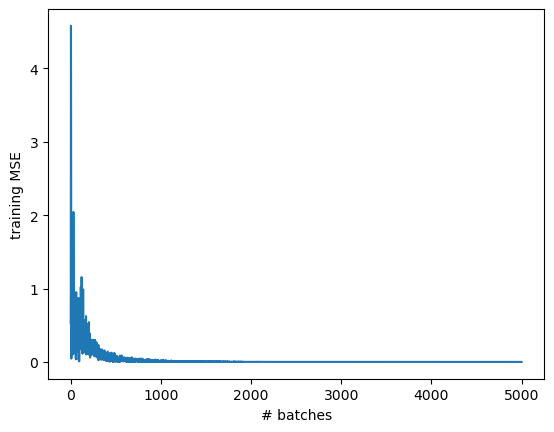

In [49]:
#plotting the learning curve
plt.plot(np.arange(1, nbatches+1), losses)
plt.xlabel("# batches")
plt.ylabel("training MSE")


##1.8 Optional Exercise

Revisit the prior section, but this time train the network using the AND, OR, and XNOR datasets. Does the network exhibit a preference in learning one dataset over the others?

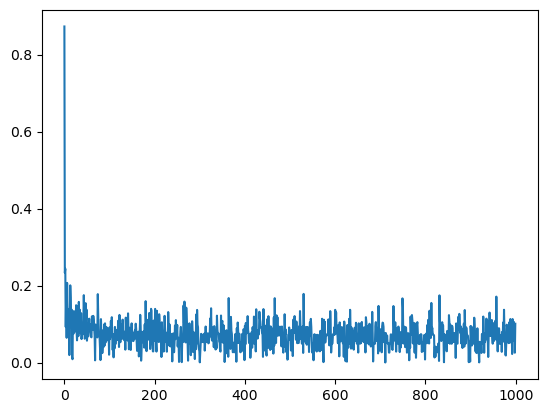

In [54]:
np.random.seed(99)

dataset = dataset_or

batch_size = 10
nbatches = 1000
lr = 0.1

input_size = 2
hidden_size = 1
output_size = 1

nn = nn_one_layer(input_size, hidden_size, output_size)

loss = np.zeros(nbatches)
for i in range(0, nbatches):
    loss_i = train_one_batch(nn, dataset, batch_size, lr)
    loss[i] = loss_i[0]


plt.plot(range(0, nbatches), loss)



#2 . Getting introduced to machine learning libraries

**Benefits of Machine Learning Libraries:**

Libraries like PyTorch handle many complexities behind the scenes, such as backpropagation, allowing for more concise and efficient code.

**Revisiting Previous Concepts with PyTorch:**

Let us implement the same neural network, loss function, and training loop using PyTorch. Notice the reduced code complexity and built-in functionalities.

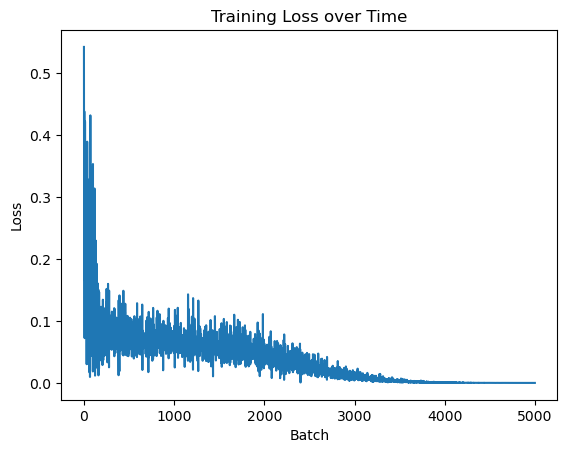

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the dataset (and operator)
data = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
labels = torch.tensor([[0], [0], [0], [1]], dtype=torch.float32)

dataset_and = list(zip(data, labels))


# Generate batch
def generate_batch(dataset, batch_size):
    inputs = torch.stack([ex[0] for ex in dataset])
    targets = torch.stack([ex[1] for ex in dataset])
    rand_inds = torch.randint(0, len(dataset), (batch_size,))
    inputs_batch = inputs[rand_inds]
    targets_batch = targets[rand_inds]
    return inputs_batch, targets_batch

# Define the neural network
class NN_OneLayer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN_OneLayer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        z = self.fc1(x)
        a = self.sigmoid(z)
        yhat = self.fc2(a)
        return yhat, a, z

# Training parameters
chosen_dataset = dataset_and
batch_size = 5
nbatches = 5000
lr = 0.1
input_size = 2
hidden_size = 5
output_size = 1

# Initialise model and optimiser
model = NN_OneLayer(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimiser = optim.SGD(model.parameters(), lr=lr)

# Training loop
losses = []
for i in range(nbatches):
    inputs, targets = generate_batch(chosen_dataset, batch_size)
    optimiser.zero_grad()
    outputs, _, _ = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

# Plotting the loss
plt.plot(losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.show()
